In [1]:
import sys, os
import numpy as np
sys.path.append('/home/nam4/Desktop/sandbox/')
import FHMCAnalysis
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_hist as hG
import FHMCAnalysis.moments.win_patch.omcs_patch as wP
import FHMCAnalysis.moments.win_patch.omcs_equil as wE

# Fluid properties at fixed T, different dMu

In [2]:
temp = 1.0

### Patch results to get single histogram

In [3]:
head = './T_%2.2f'%temp

In [4]:
dmu2_dirs = [(x, float(x.split('_')[1])) for x in os.listdir(head) if 'dMu2' in x]
dmu2_dirs = sorted(dmu2_dirs, key=lambda x: x[1])

In [5]:
trim = 1
smoothOverlap = True
for d, dMu2 in dmu2_dirs:
    src = head+'/'+d
    seq = wP.get_patch_sequence(src, True)
    composite = src+'/composite.nc'
    wP.patch_all_windows(seq, composite, src+'/patch.log', trim, smoothOverlap)

### Create histograms

In [6]:
beta_ref = 1.0/temp # Simulations were performed at 1/T = 0.0
smooth = 10 # How many points in N_tot space to smooth lnPI over when looking for maxima

histograms = []
for d, dMu2 in dmu2_dirs:
    mu_ref = [0.0, dMu2] # Simulations were performed at mu_1 = 0
    composite = head+'/'+d+'/composite.nc'
    hist = hG.histogram (composite, beta_ref, mu_ref, smooth)
    histograms.append((dMu2,hist))

### Test some reweighting

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
target_beta = beta_ref + 0.0
order = 2

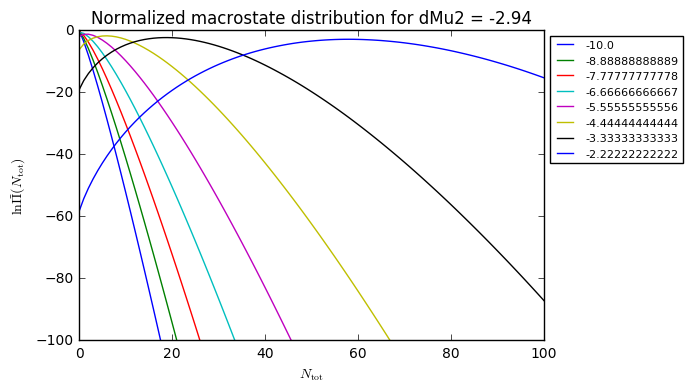

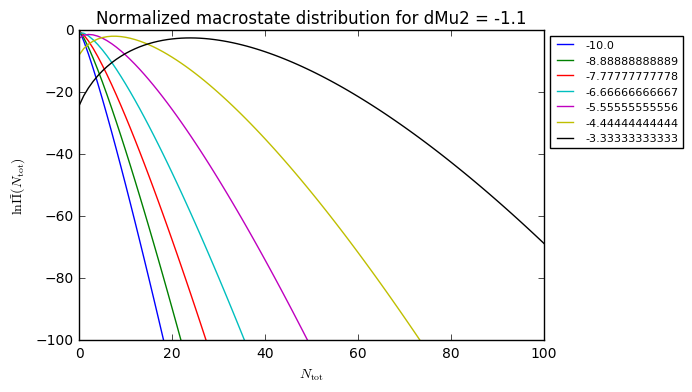

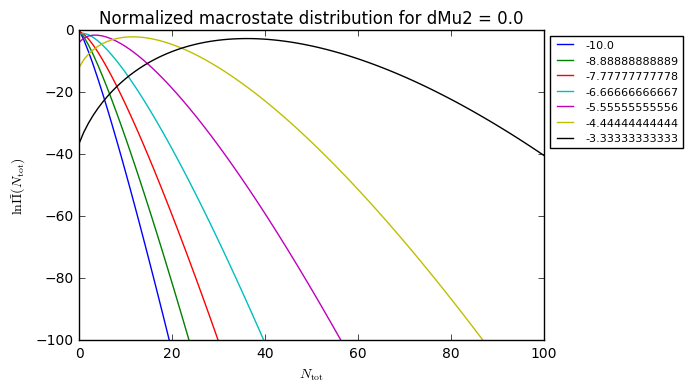

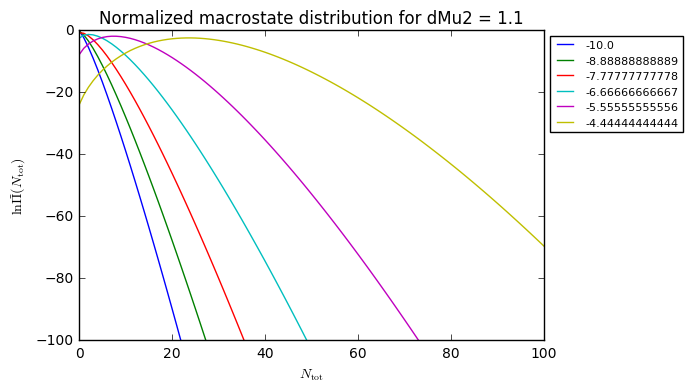

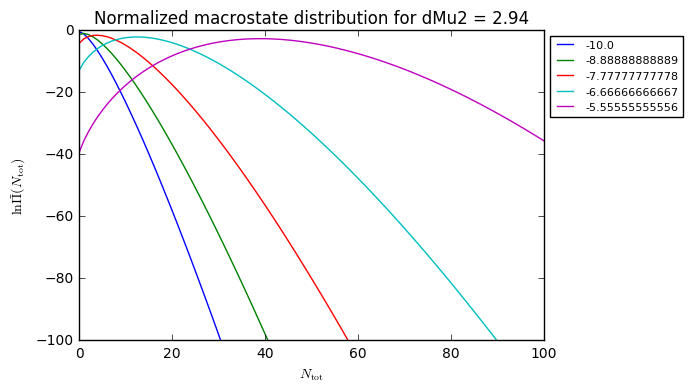

In [9]:
for dMu2, hist in histograms:
    lnPI = []
    target_dmu2 = np.array([dMu2])
    for mu_1 in np.linspace(-10,0,10):
        hist.reweight(mu_1) 
        
        try:
            hist_new = hist.temp_dmu_extrap(target_beta, target_dmu2, order, 10, True)
        
            if (hist_new.is_safe()): 
                hist_new.thermo() 
                result = hist_new.data['thermo']
                lnPI.append((hist_new.data['ln(PI)'], mu_1))
        except Exception as e:
            print e
            pass
        
    plt.figure()
    n = np.arange(len(lnPI[0][0]))
    for lp in lnPI:
        plt.plot(n, lp[0], label=str(lp[1]))
    plt.xlabel(r'$N_{\rm tot}$')
    plt.ylabel(r'${\rm ln}{\tilde{\Pi}}(N_{\rm tot})$')
    plt.title('Normalized macrostate distribution for dMu2 = '+str(dMu2))
    plt.legend(loc='best', prop={'size':8}, bbox_to_anchor=(1,1))
    plt.ylim(-100, 0)

## Create 2D grid for isopleths

In [10]:
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_binary as gB
import matplotlib.pyplot as plt

In [11]:
iso = gB.isopleth ([x[1] for x in histograms], target_beta, order)

In [12]:
grid_x1, grid_mu = iso.make_grid_multi([-10, -5.5], [-3, 3], [0.2, 0.2], p=4)

(-5, 5)

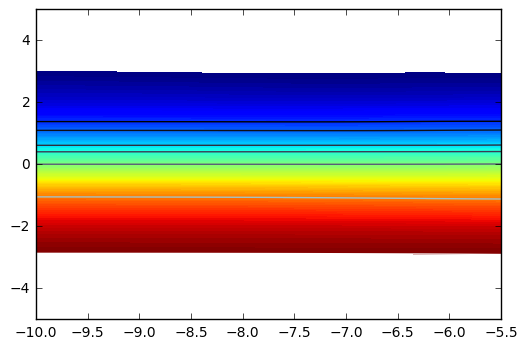

In [13]:
csf = plt.contourf(grid_mu[0], grid_mu[1], grid_x1, levels=np.linspace(0.05, 0.95, 100))#, cmap='bwr')
cs = plt.contour(grid_mu[0], grid_mu[1], grid_x1, [0.20, 0.25, 0.35, 0.40, 0.50, 0.75, 0.95], cmap='bone')
plt.ylim(-5,5)

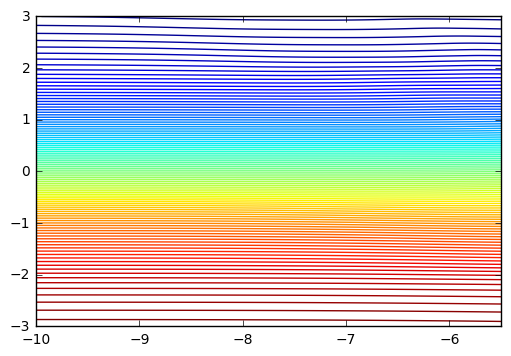

In [14]:
grid_x1_z, grid_mu_z, rho, fe = iso.zoom(10,2)
csf2 = plt.contour(grid_mu_z[0], grid_mu_z[1], grid_x1_z, levels=np.linspace(0.05, 0.95, 100))

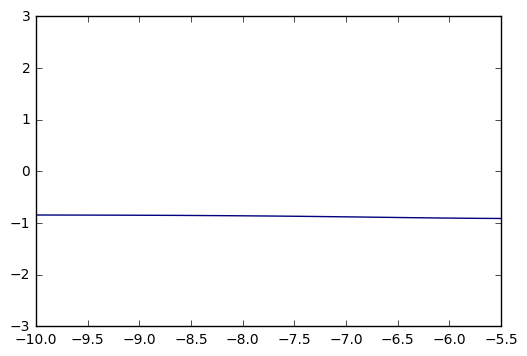

In [15]:
mu_vals = gB.get_iso (0.71, grid_x1, grid_mu[0], grid_mu[1])

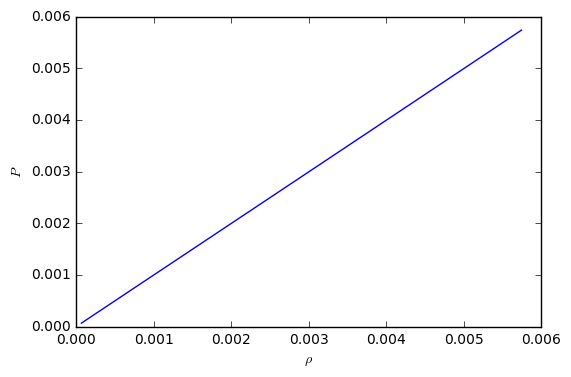

In [16]:
xy = gB.parameterize_mesh (grid_mu[0], grid_mu[1], iso.data['density'], iso.data['F.E./kT'], mu_vals)
P = np.array([-x[1] for x in xy])/8.0**3/target_beta
plt.plot([x[0] for x in xy], P)
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P$')

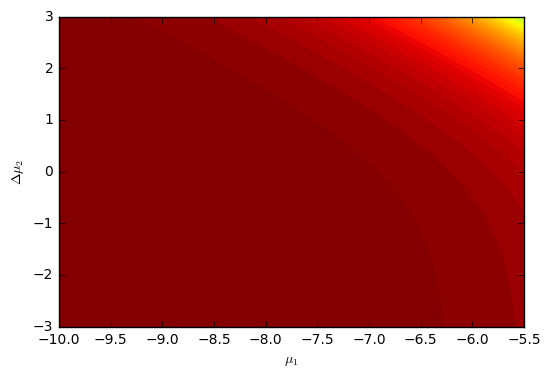

In [17]:
csf = plt.contourf(grid_mu[0], grid_mu[1], iso.data['F.E./kT'], levels=np.linspace(-100, 0, 100))
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\Delta \mu_2$')

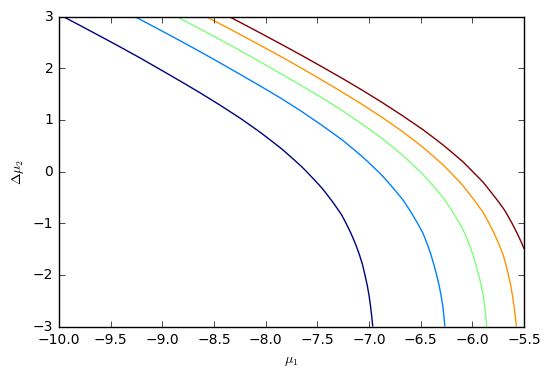

In [18]:
cs = plt.contour(grid_mu[0], grid_mu[1], iso.data['density'], levels=[0.001, 0.002, 0.003, 0.004, 0.005])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\Delta \mu_2$')

## Check if extrapolated extensive properties are consistent

In [19]:
histograms

[(-2.94, <gc_hist.histogram at 0x7f94eb07ff10>),
 (-1.1, <gc_hist.histogram at 0x7f94eb07ffd0>),
 (0.0, <gc_hist.histogram at 0x7f94eb07ff90>),
 (1.1, <gc_hist.histogram at 0x7f95200ae650>),
 (2.94, <gc_hist.histogram at 0x7f94eb07ff50>)]

In [20]:
# Pick some mu1 to compare at 
mu_1 = -3.0

chosen = histograms[1][1]
chosen.reweight(mu_1)

N1_a = chosen.data['mom'][0,1,0,0,0]
N2_a = chosen.data['mom'][1,1,0,0,0]
U_a = chosen.data['mom'][0,0,0,0,1]
X_a = chosen.data['mom'][0,1,1,1,0]
lnPI_a = chosen.data['ln(PI)']

# extrapolate dmu = 0 to dmu = -1.1
chosen = histograms[2][1]
chosen.reweight(mu_1)
hist_ext = chosen.temp_dmu_extrap(target_beta, np.array([-1.1]), order, 10, True)
N1_b = hist_ext.data['mom'][0,1,0,0,0]
N2_b = hist_ext.data['mom'][1,1,0,0,0]
U_b = hist_ext.data['mom'][0,0,0,0,1]
X_b = hist_ext.data['mom'][0,1,1,1,0]
lnPI_b = hist_ext.data['ln(PI)']

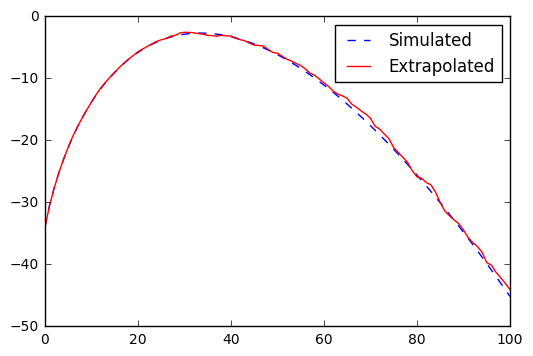

In [21]:
plt.plot(lnPI_a, 'b--', label='Simulated')
plt.plot(lnPI_b, 'r-', label='Extrapolated')
plt.legend(loc='best')

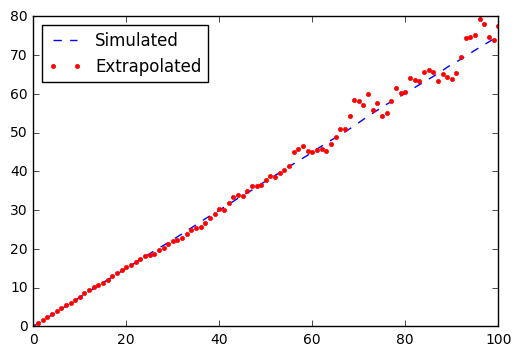

In [22]:
plt.plot(N1_a, 'b--', label='Simulated')
plt.plot(N1_b, 'r.', label='Extrapolated')
plt.legend(loc='best')

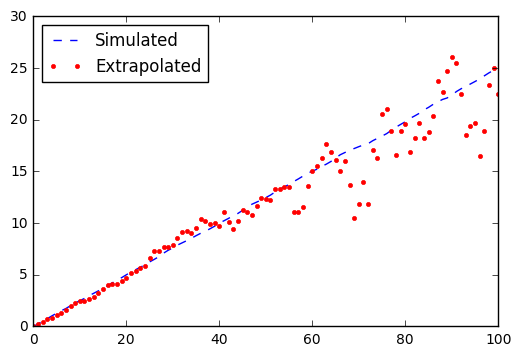

In [23]:
plt.plot(N2_a, 'b--', label='Simulated')
plt.plot(N2_b, 'r.', label='Extrapolated')
plt.legend(loc='best')

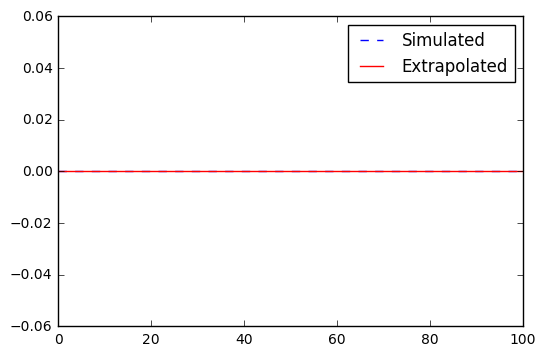

In [24]:
plt.plot(U_a, 'b--', label='Simulated')
plt.plot(U_b, 'r-', label='Extrapolated')
plt.legend(loc='best')

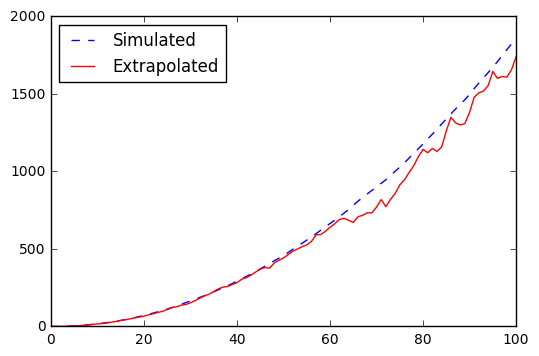

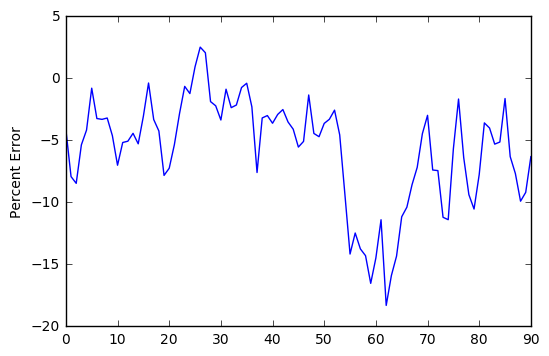

In [25]:
plt.figure()
plt.plot(X_a, 'b--', label='Simulated')
plt.plot(X_b, 'r-', label='Extrapolated')
plt.legend(loc='best')

plt.figure()
plt.plot((X_b[10:]-X_a[10:])/X_a[10:]*100)
plt.ylabel('Percent Error')

# Compare for T + dMu extrapolation

In [26]:
tt = 1.20
head = './T_%2.2f'%tt

In [27]:
dmu2_dirs = [(x, float(x.split('_')[1])) for x in os.listdir(head) if 'dMu2' in x]
dmu2_dirs = sorted(dmu2_dirs, key=lambda x: x[1])

In [28]:
trim = 1
smoothOverlap = True
for d, dMu2 in dmu2_dirs:
    src = head+'/'+d
    seq = wP.get_patch_sequence(src, True)
    composite = src+'/composite.nc'
    wP.patch_all_windows(seq, composite, src+'/patch.log', trim, smoothOverlap)

In [29]:
smooth = 10 # How many points in N_tot space to smooth lnPI over when looking for maxima
beta_ref_new = 1.0/1.20 

histograms2 = []
for d, dMu2 in dmu2_dirs:
    mu_ref = [0.0, dMu2] # Simulations were performed at mu_1 = 0
    composite = head+'/'+d+'/composite.nc'
    hist = hG.histogram (composite, beta_ref_new, mu_ref, smooth)
    histograms2.append((dMu2,hist))

### Just Temperature at first

Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation


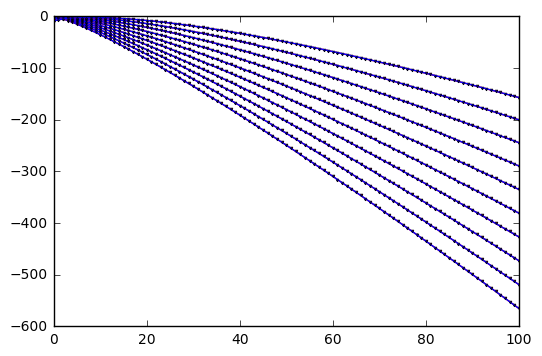

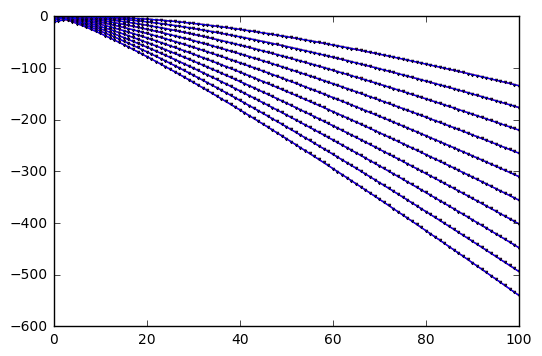

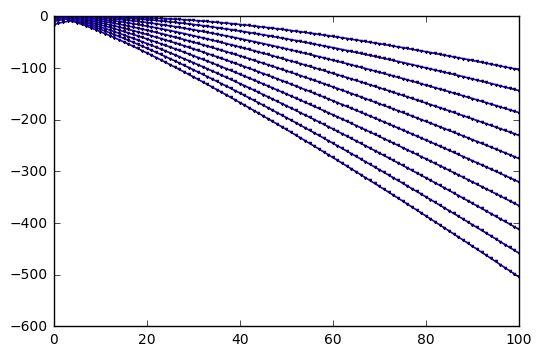

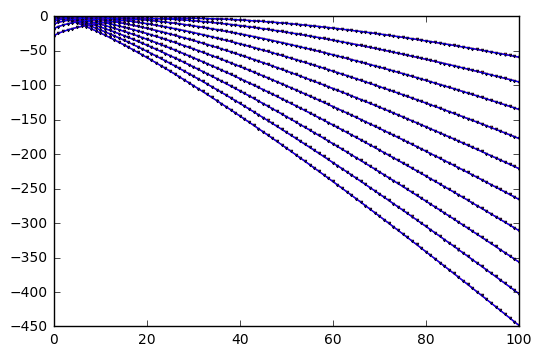

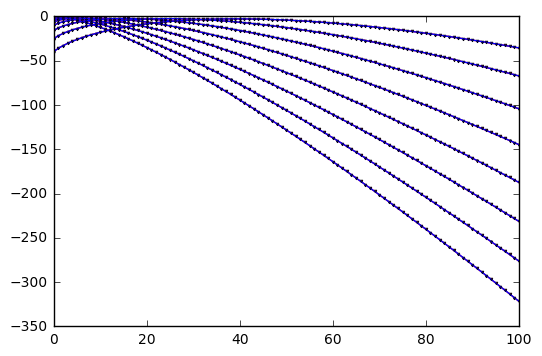

In [30]:
for a,b in zip(histograms, histograms2):
    dMu2, hist = a
    dMu2_2, hist_2 = b
    
    lnPI = []
    lnPI_2 = []
    target_dmu2 = np.array([dMu2])
    assert (dMu2 == dMu2_2), 'dmu not equal'
    
    plt.figure()
    for mu_1 in np.linspace(-10,-5,10):
        hist.reweight(mu_1) 
        hist_2.reweight(mu_1) 
        
        try:
            hist_new = hist.temp_dmu_extrap(1/1.2, target_dmu2, order, 10)
        
            if (hist_new.is_safe()): 
                hist_new.thermo() 
                result = hist_new.data['thermo']
                lnPI.append((hist_new.data['ln(PI)'], mu_1))
                lnPI_2.append((hist_2.data['ln(PI)'], mu_1))
                
                plt.plot(hist_new.data['ln(PI)'], color='r', marker='v', ms=2)
                plt.plot(hist_2.data['ln(PI)'], color='b', marker='o', ms=1)
        except Exception as e:
            print e
            pass
        

In [31]:
iso = gB.isopleth ([x[1] for x in histograms2], 1/1.20, order)

In [32]:
grid_x1, grid_mu = iso.make_grid_multi([-10, -5.5], [-3, 3], [0.2, 0.2], p=4)

Error during extrapolation : Unable to extrapolate : Error, histogram edge effect encountered in temperature extrapolation


(-5, 5)

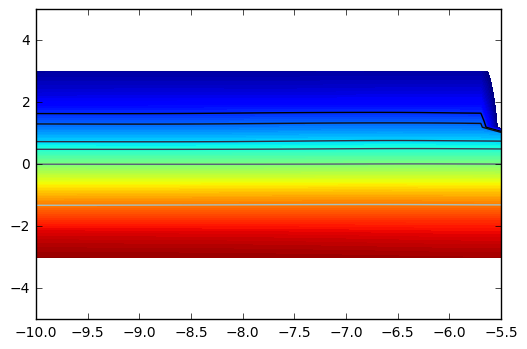

In [33]:
csf = plt.contourf(grid_mu[0], grid_mu[1], grid_x1, levels=np.linspace(0.05, 0.95, 100))#, cmap='bwr')
cs = plt.contour(grid_mu[0], grid_mu[1], grid_x1, [0.20, 0.25, 0.35, 0.40, 0.50, 0.75, 0.95], cmap='bone')
plt.ylim(-5,5)

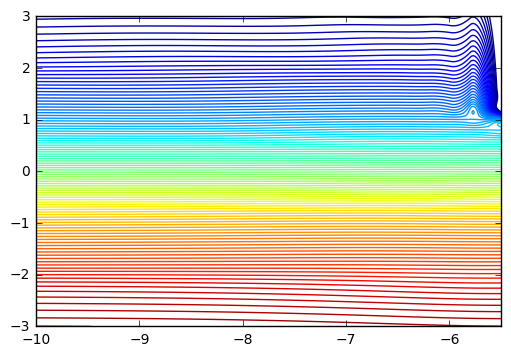

In [34]:
grid_x1_z, grid_mu_z, rho, fe = iso.zoom(10,2)
csf2 = plt.contour(grid_mu_z[0], grid_mu_z[1], grid_x1_z, levels=np.linspace(0.05, 0.95, 100))

-1.44997344711 -1.43481980765


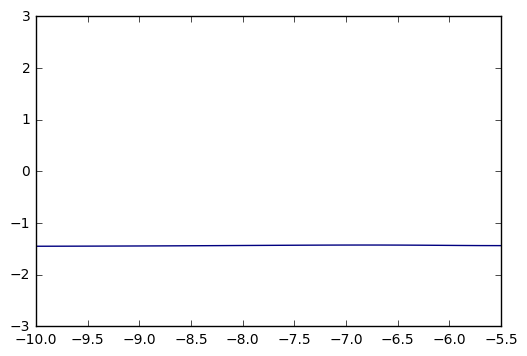

In [35]:
x1 = 0.77
mu_vals = gB.get_iso (x1, grid_x1, grid_mu[0], grid_mu[1])
dmu_ideal = np.log(1/x1-1.0)/(1.0/1.20)
print dmu_ideal, np.mean([x[1] for x in mu_vals])

### T and dMu now

In [36]:
histograms2, histograms

([(-2.94, <gc_hist.histogram at 0x7f94e674f050>),
  (-1.1, <gc_hist.histogram at 0x7f94e8dc7790>),
  (0.0, <gc_hist.histogram at 0x7f94e8dc7cd0>),
  (1.1, <gc_hist.histogram at 0x7f94e8dc7d90>),
  (2.94, <gc_hist.histogram at 0x7f94e673fc90>)],
 [(-2.94, <gc_hist.histogram at 0x7f94eb07ff10>),
  (-1.1, <gc_hist.histogram at 0x7f94eb07ffd0>),
  (0.0, <gc_hist.histogram at 0x7f94eb07ff90>),
  (1.1, <gc_hist.histogram at 0x7f95200ae650>),
  (2.94, <gc_hist.histogram at 0x7f94eb07ff50>)])

### Take dmu2 = 0, T = 1.20 and extapolate to dmu2 = -1.1, T = 1.00
mu_1 = -4.0
order = 2

histograms2[2][1].reweight(mu_1)
hist2 = histograms2[2][1].temp_dmu_extrap(1/1.00, np.array([-1.1]), order, 10)

histograms[1][1].reweight(mu_1)

plt.figure()
plt.plot(hist2.data['ln(PI)'], 'r')
plt.plot(histograms[1][1].data['ln(PI)'], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,1,0,0,0], 'r')
plt.plot(histograms[1][1].data['mom'][0,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][1,1,0,0,0], 'r')
plt.plot(histograms[1][1].data['mom'][1,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][1,1,0,0,0]+hist2.data['mom'][0,1,0,0,0], 'r')
plt.plot(histograms[1][1].data['mom'][1,1,0,0,0]+histograms[1][1].data['mom'][0,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,0,0,0,1], 'r')
plt.plot(histograms[1][1].data['mom'][0,0,0,0,1], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,1,1,1,0], 'r')
plt.plot(histograms[1][1].data['mom'][0,1,1,1,0], 'b')

# Neighboring dMu2 pair is quite good

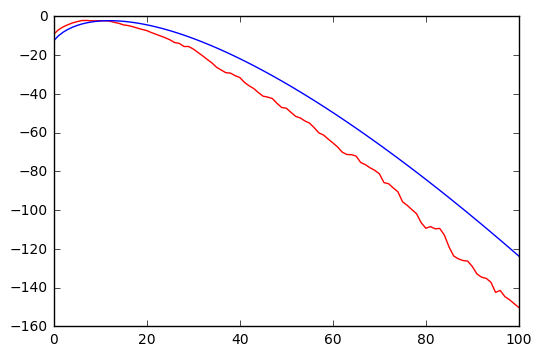

In [39]:
# Take dmu2 = 0, T = 1.20 and extapolate to dmu2 = -2.94, T = 1.00
mu_1 = -4.0

histograms2[2][1].reweight(mu_1)
hist2 = histograms2[2][1].temp_dmu_extrap(1/1.00, np.array([-2.94]), order, 10)

histograms[1][1].reweight(mu_1)

plt.plot(hist2.data['ln(PI)'], 'r')
plt.plot(histograms[1][1].data['ln(PI)'], 'b')

# This is too far, however....

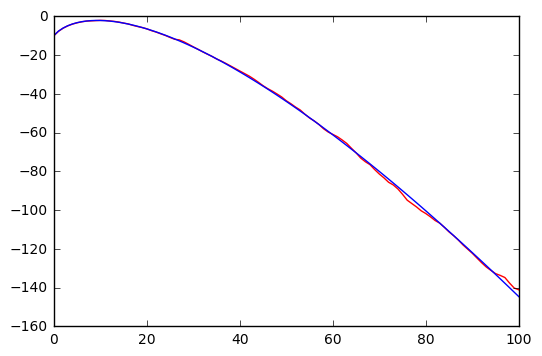

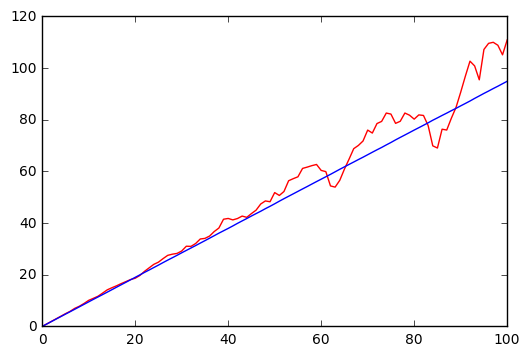

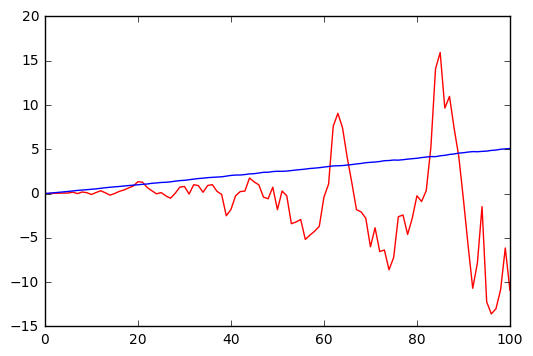

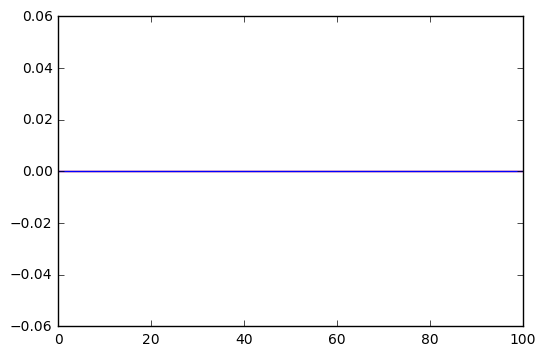

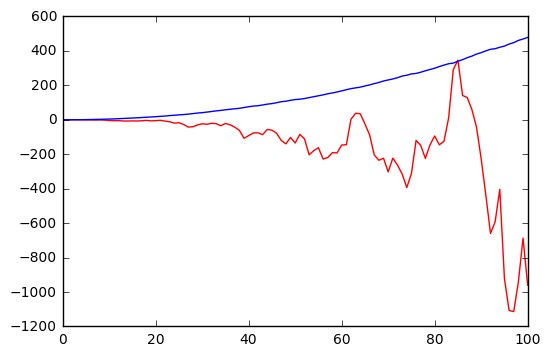

In [40]:
# Take dmu2 = -1.1, T = 1.20 and extapolate to dmu2 = -2.94, T = 1.00
mu_1 = -4.0
order =2

histograms2[1][1].reweight(mu_1)
hist2 = histograms2[1][1].temp_dmu_extrap(1/1.00, np.array([-2.94]), order, 10)

histograms[0][1].reweight(mu_1)

plt.figure()
plt.plot(hist2.data['ln(PI)'], 'r')
plt.plot(histograms[0][1].data['ln(PI)'], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,1,0,0,0], 'r')
plt.plot(histograms[0][1].data['mom'][0,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][1,1,0,0,0], 'r')
plt.plot(histograms[0][1].data['mom'][1,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,0,0,0,1], 'r')
plt.plot(histograms[0][1].data['mom'][0,0,0,0,1], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,1,1,1,0], 'r')
plt.plot(histograms[0][1].data['mom'][0,1,1,1,0], 'b')

# This "neighboring" dMu2 pair is still good!

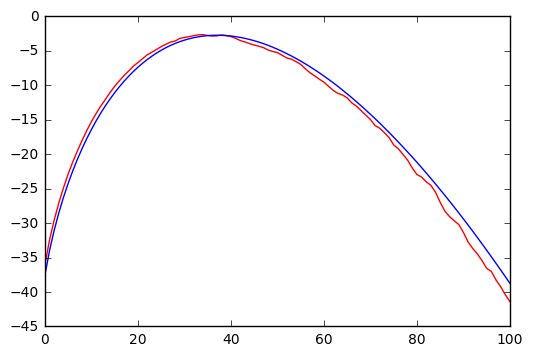

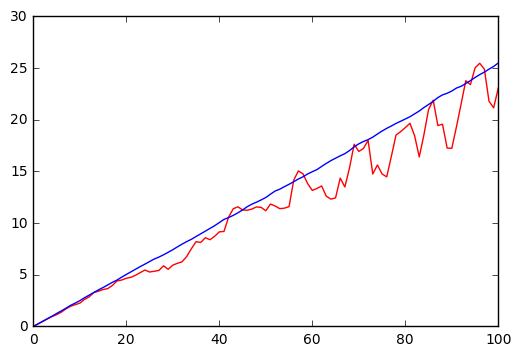

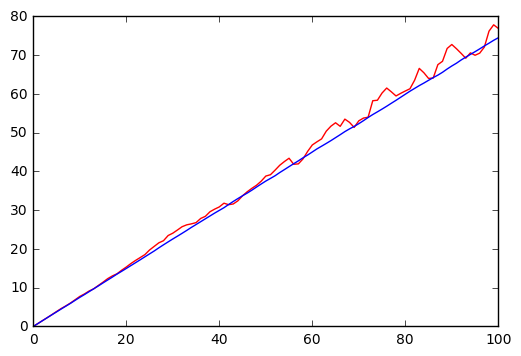

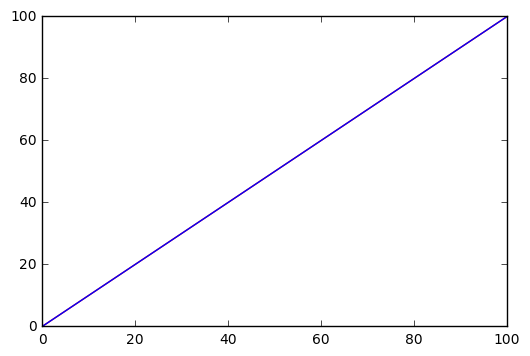

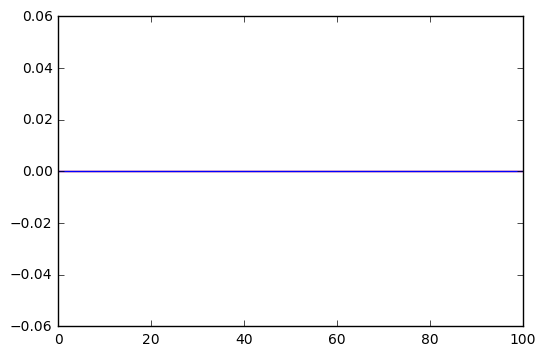

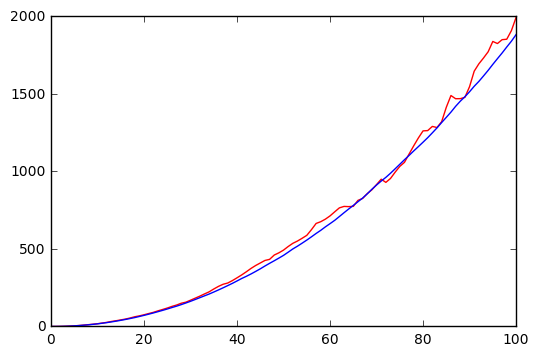

In [43]:
# Take dmu2 = 0, T = 1.20 and extapolate to dmu2 = 1.1, T = 1.00
mu_1 = -4.0
order = 2

histograms2[2][1].reweight(mu_1)
hist2 = histograms2[2][1].temp_dmu_extrap(1/1.00, np.array([1.1]), order, 10)

histograms[3][1].reweight(mu_1)

plt.figure()
plt.plot(hist2.data['ln(PI)'], 'r')
plt.plot(histograms[3][1].data['ln(PI)'], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,1,0,0,0], 'r')
plt.plot(histograms[3][1].data['mom'][0,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][1,1,0,0,0], 'r')
plt.plot(histograms[3][1].data['mom'][1,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][1,1,0,0,0]+hist2.data['mom'][0,1,0,0,0], 'r')
plt.plot(histograms[3][1].data['mom'][1,1,0,0,0]+histograms[3][1].data['mom'][0,1,0,0,0], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,0,0,0,1], 'r')
plt.plot(histograms[3][1].data['mom'][0,0,0,0,1], 'b')

plt.figure()
plt.plot(hist2.data['mom'][0,1,1,1,0], 'r')
plt.plot(histograms[3][1].data['mom'][0,1,1,1,0], 'b')

# Neighboring dMu2 pair is quite good